# Example 8: Continual Learning

Setup: Our goal is to learn a 1D function from samples. The 1D function has 5 Gaussian peaks. Instead of presenting all samples to NN all at once, we have five phases of learning. In each phase only samples around one peak is presented to KAN. We find that KANs can do continual learning thanks to locality of splines.

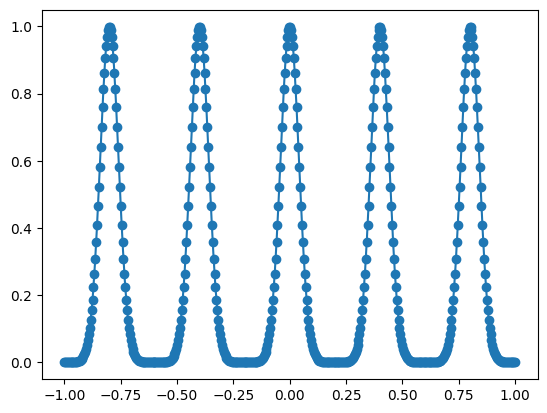

In [1]:
from better_kan import *
from kan import  KAN as BaseKAN
import numpy as np
import torch
import matplotlib.pyplot as plt


datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)


y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)
    
y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)
    

plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

Sequentially prensenting different peaks to KAN

Text(0.5, 1.0, 'Train Data')

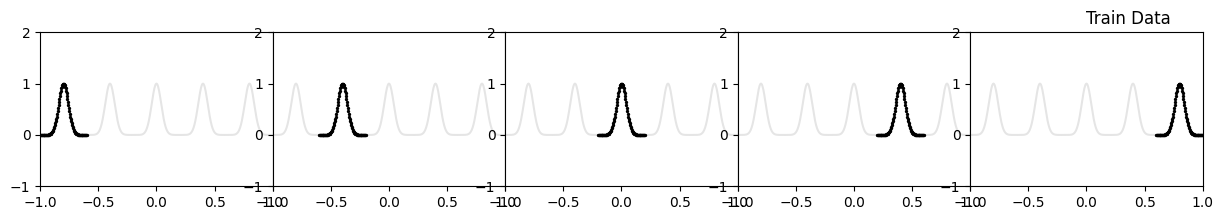

In [2]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.title(f"Train Data",ha='left')

In [3]:
# ys = []
# import tqdm
# # setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# # otherwise KAN will have random scaling and shift for samples in previous stages

# model = torch.nn.Sequential(
#     torch.nn.Linear(1, 256, bias=True),
#     torch.nn.ReLU(),
#     torch.nn.Linear(256, 256, bias=True),
#     torch.nn.ReLU(),
#     torch.nn.Linear(256, 1, bias=True)
                    
# )

# for group_id in range(n_peak):
#     dataset = {}
#     dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
#     dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
#     dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
#     dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
#     opt=torch.optim.Adam(model.parameters(), lr=1e-1)
#     x=dataset['train_input']
#     y=dataset['train_label']
#     print(x.shape, y.shape)
#     for i in tqdm.tqdm( range(100)):
        
#         def closure():
#             opt.zero_grad()
#             y_pred = model(x)
#             loss = torch.nn.functional.mse_loss(y_pred, y)
#             loss.backward()
#             return loss
#         opt.step(closure)
#     y_pred = model(x_grid[:,None])
#     print(y_pred.shape)
#     ys.append(model(x)[:,0].detach().numpy())
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages
import tqdm
model = torch.nn.Sequential(
    torch.nn.Linear(1, 256, bias=True),
    torch.nn.Tanh(),
    torch.nn.Linear(256, 256, bias=True),
    torch.nn.Tanh(),
    torch.nn.Linear(256, 1, bias=True)
                    
)
for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    # model.train(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    opt=torch.optim.LBFGS(model.parameters(), lr=1e-1)
    for i in tqdm.tqdm( range(100)):
            
            def closure():
                opt.zero_grad()
                y_pred = model(dataset['train_input'])
                loss = torch.nn.functional.mse_loss(y_pred, dataset['train_label'])
                loss.backward()
                return loss
            opt.step(closure)   
    
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Text(0.5, 1.0, 'MLP')

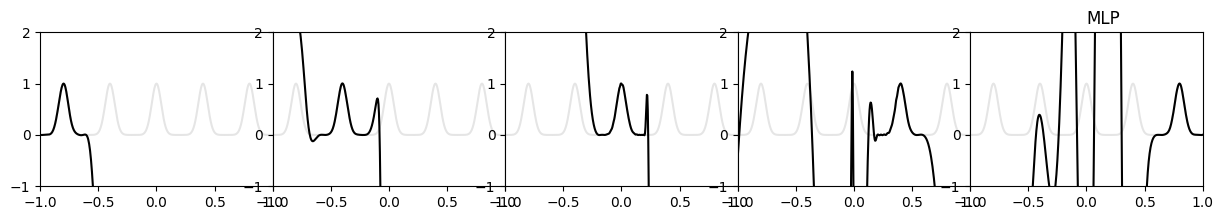

In [4]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.title(f"MLP",ha='left')

Training KAN

In [5]:
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = BaseKAN(width=[1,1],grid=200,sp_trainable=False,sb_trainable=False,bias_trainable=False)

for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    model.train(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

train loss: 4.00e-06 | test loss: 4.00e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:02<00:00, 35.18it/s
train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:03<00:00, 29.93it/s
train loss: 4.01e-06 | test loss: 4.01e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:03<00:00, 28.06it/s
train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:02<00:00, 35.01it/s
train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:02<00:00, 36.72it/s


Prediction of KAN after each stage

Text(0.5, 1.0, 'Base KAN')

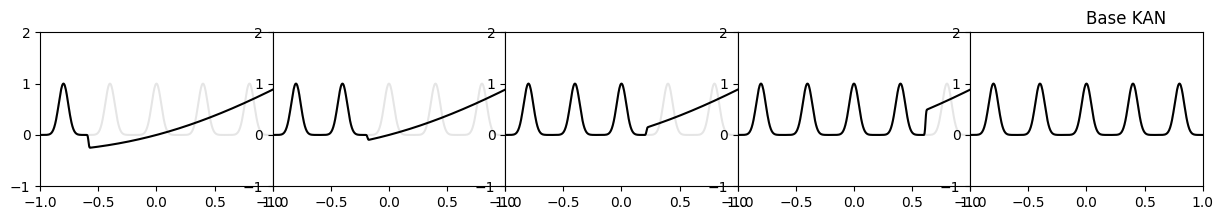

In [6]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.title(f"Base KAN",ha='left')

In [7]:
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[1,1], num_basis=200,bias_trainable=False,basis_trainable=True,seed=0)

for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    model.train(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])


train loss: 1.10e-04 | test loss: 1.10e-04 | reg: 0.00e+00 : 100%|█| 100/100 [00:03<00:00, 25.47it/s
train loss: 1.30e-04 | test loss: 1.30e-04 | reg: 0.00e+00 : 100%|█| 100/100 [00:02<00:00, 38.00it/s
train loss: 5.84e-05 | test loss: 5.84e-05 | reg: 0.00e+00 : 100%|█| 100/100 [00:02<00:00, 35.01it/s
train loss: 1.13e-05 | test loss: 1.13e-05 | reg: 0.00e+00 : 100%|█| 100/100 [00:05<00:00, 19.65it/s
train loss: 1.06e-05 | test loss: 1.06e-05 | reg: 0.00e+00 : 100%|█| 100/100 [00:05<00:00, 18.66it/s


Text(0.5, 1.0, 'Guassian KAN')

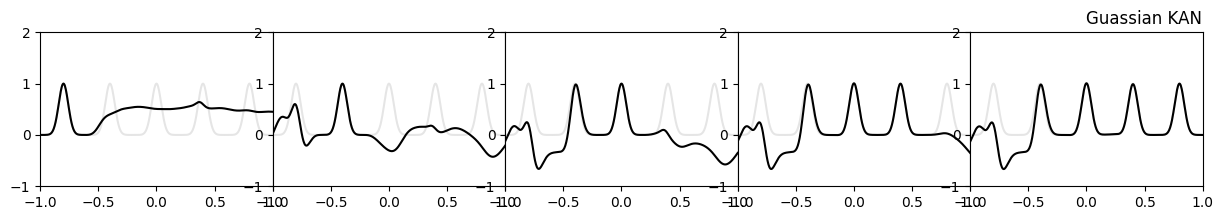

In [8]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.title(f"Guassian KAN",ha='left')